In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import spacy
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt


In [2]:
pd.read_csv("./SMSSpamCollection.txt", sep="\t", header=None).to_csv("sms_spam_collection.csv", index=False, header=["label", "message"])

In [3]:
data = pd.read_csv("sms_spam_collection.csv")
data

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [4]:
X = data.drop("label", axis=1)
y = data["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
display(X_train.shape) 
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(4457, 1)

(1115, 1)

(4457,)

(1115,)

In [5]:
#Display message counts
hams = data[(data['label'] == 'ham')]
spams = data[(data['label'] == 'spam')]
hams_count = hams.value_counts().sum()
spams_count = spams.value_counts().sum()
total_messages = hams_count + spams_count
spam_fraction = spams_count / total_messages

print("Number of ham messages: ", hams_count)
print("Number of spam messages: ", spams_count)
print("Fraction of spam messages: {:.2f}%".format(spam_fraction * 100))



Number of ham messages:  4825
Number of spam messages:  747
Fraction of spam messages: 13.41%


# Bayesian Model

In [6]:
nlp = spacy.load("en_core_web_sm")
def custom_spacy_tokenizer(text):
        doc = nlp(text)
        return [token.lemma_.lower().strip() for token in doc if not token.is_stop and not token.is_punct]
# texts_to_process = (text for text in data['message'])

# processed_docs = []
# for doc in nlp.pipe(texts_to_process): # Adjust batch_size as needed
#     processed_docs.append(doc)

# #processed_docs

In [7]:
# tokens_list = []

# for doc in processed_docs:
#     tokens_list.append([token.text for token in doc])

# data['tokens'] = tokens_list
# data

In [8]:
# custom_vocabulary = {'document': 0, 'first': 1, 'is': 2, 'the': 3}
vectorizer = CountVectorizer(tokenizer=custom_spacy_tokenizer, strip_accents='unicode', lowercase=True)
X_train_vectorized = vectorizer.fit_transform(X_train['message'])
vectorizer.get_feature_names_out()
X_test_vectorized = vectorizer.transform(X_test['message'])

/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [9]:
display(X_train_vectorized.shape)
display(X_test_vectorized.shape)
display(y_train.shape)
display(y_test.shape)

(4457, 7158)

(1115, 7158)

(4457,)

(1115,)

In [10]:
classifier = MultinomialNB()
classifier.fit(X_train_vectorized, y_train)

MultinomialNB()

In [11]:
print("Training accuracy: ", classifier.score(X_train_vectorized, y_train))
print("Test accuracy: ", classifier.score(X_test_vectorized, y_test))

Training accuracy:  0.9925959165357864
Test accuracy:  0.9865470852017937


# Bayesian Training Results

In [12]:
training_values = cross_val_score(classifier, X_train_vectorized, y_train, cv=5)
print("Cross-validation scores: ", training_values)

Cross-validation scores:  [0.97757848 0.96973094 0.98204265 0.97530864 0.98316498]


In [13]:
np_training_values = np.array(training_values)
average = np.mean(np_training_values)
stDev = np.std(np_training_values)
print(average.round(2), " +/- ", stDev.round(4))

0.98  +/-  0.0049


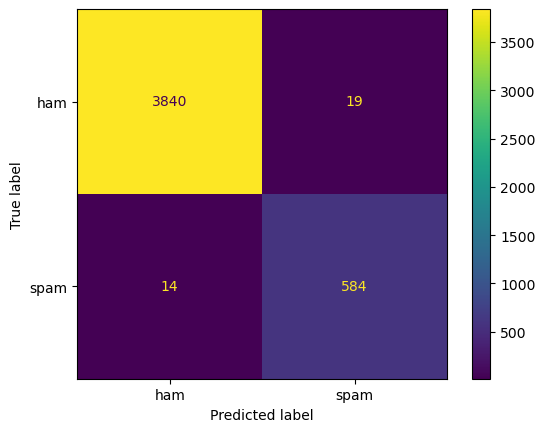

In [14]:
#Training Confusion Matrix
ConfusionMatrixDisplay.from_estimator(classifier, X_train_vectorized, y_train)

# Bayesian Testing Results

In [15]:
test_values = cross_val_score(classifier, X_test_vectorized, y_test, cv=5)
print("Cross-validation scores: ", test_values)

Cross-validation scores:  [0.97757848 0.97757848 0.97757848 0.98654709 0.98654709]


In [16]:
np_testing_values = np.array(test_values)
average = np.mean(np_testing_values)
stDev = np.std(np_testing_values)
print(average.round(2), " +/- ", stDev.round(4))

0.98  +/-  0.0044


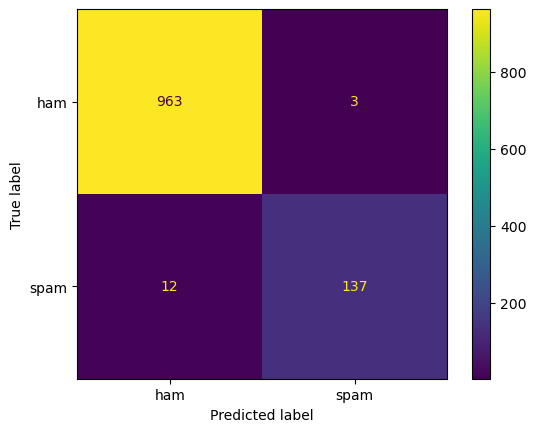

In [17]:
#Training Confusion Matrix
ConfusionMatrixDisplay.from_estimator(classifier, X_test_vectorized, y_test)

<ol>
<li>Did your classifier perform better than one that always predicted "ham"?</li></br>
<li>Were your testing metrics within the "bounds" set by your train/validation split (mean +/- std dev)?</li></br>
<li>Would you use this "bare" classifier as a filter on your own messages?</li></br>
</ol>

# Bayesian Training Learning Curve

In [18]:
train_sizes, train_scores, test_scores = learning_curve(
    classifier,
    X_train_vectorized,
    y_train,
    cv=5,  # Number of folds for cross-validation
    scoring='accuracy',  # Metric to evaluate the model
    n_jobs=-1,  # Use all available CPU cores
)

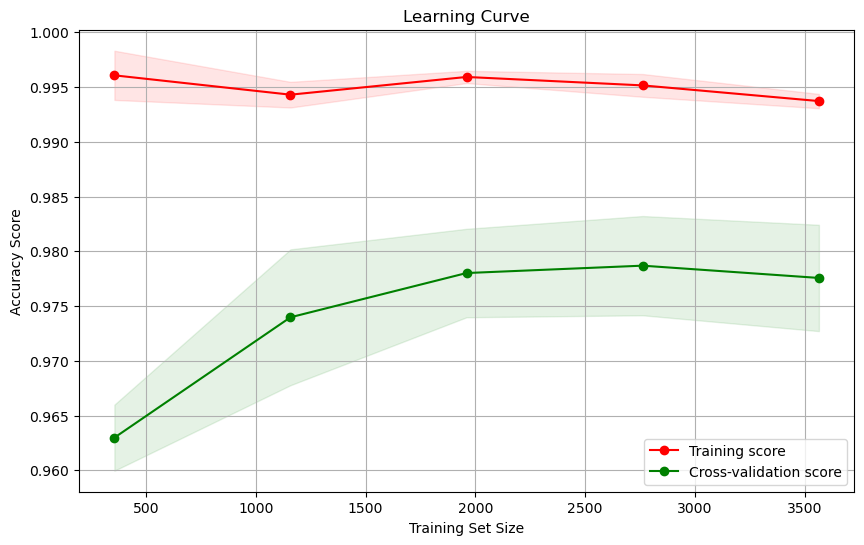

In [19]:
# Calculate mean and standard deviation for scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()

<p>
What this learning curve is telling you about how your algorithm might perform if given more data.  That is, does it appear to still be learning even as you get to larger input sizes?  Phrased another way, if you built an App to classify spam SMS messages, would that App be able to learn/improve from your user's classification of messages?
</p>

# TFIDF and Logistic Classifier

In [20]:
X_train.shape
#y_train.shape

(4457, 1)

In [ ]:
# tdidf_vectorizer = TfidfVectorizer(tokenizer=custom_spacy_tokenizer, use_idf=False)
# X_train_vectorized2 = tdidf_vectorizer.fit_transform(X_train['message'])
# print(X_train_vectorized2.shape)

/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(4457, 7163)


In [43]:
y_train = np.array(y_train)
display(y_train)

display(X_train)

array(['spam', 'ham', 'ham', ..., 'ham', 'ham', 'ham'], dtype=object)

,message
1978,Reply to win £100 weekly! Where will the 2006 ...
3989,Hello. Sort of out in town already. That . So ...
3935,How come guoyang go n tell her? Then u told her?
4078,Hey sathya till now we dint meet not even a si...
4086,Orange brings you ringtones from all time Char...
...,...
3772,"Hi, wlcome back, did wonder if you got eaten b..."
5191,"Sorry, I'll call later"
5226,Prabha..i'm soryda..realy..frm heart i'm sory
5390,Nt joking seriously i told


In [47]:
X = data.drop("label", axis=1)
y = data["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
display(X_train.shape) 
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(4457, 1)

(1115, 1)

(4457,)

(1115,)

In [ ]:
# # Explicitly make a writeable copy

# X_train = X_train.copy()
# # if not X_test.flags['WRITEABLE']:
# #     X_test = X_test.copy()
# # if not y_train.flags['WRITEABLE']:
# #     y_train = y_train.copy()
# # if not y_test.flags['WRITEABLE']:
# #     y_test = y_test.copy()

In [52]:
pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer(tokenizer=custom_spacy_tokenizer)),
        ("clf", LogisticRegression())
    ]
)
param_grid = {
    "clf__penalty": ['l1', 'l2'], 
    "clf__C": [450, 475, 500, 515, 530], 
    # "vect__use_idf": [True, False],
    # "vect__tokenizer": [custom_spacy_tokenizer]
}

model = GridSearchCV(pipeline, param_grid=param_grid, n_jobs=-1)
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_train
# pred_train = model.predict(X_train)
# pred_test= model.predict(X_test)

/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packa

ValueError: 
All the 50 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/pipeline.py", line 654, in fit
    Xt = self._fit(X, y, routed_params, raw_params=params)
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/pipeline.py", line 588, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ~~~~~~~~~~~~~~~~~~~~~~~~^
        cloned_transformer,
        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
        params=step_params,
        ^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/opt/anaconda3/lib/python3.13/site-packages/joblib/memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
           ~~~~~~~~~^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/pipeline.py", line 1551, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_extraction/text.py", line 2104, in fit_transform
    X = super().fit_transform(raw_documents)
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_extraction/text.py", line 1376, in fit_transform
    vocabulary, X = self._count_vocab(raw_documents, self.fixed_vocabulary_)
                    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_extraction/text.py", line 1263, in _count_vocab
    for feature in analyze(doc):
                   ~~~~~~~^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_extraction/text.py", line 106, in _analyze
    doc = tokenizer(doc)
  File "/var/folders/0_/nmh5w64x3q5_ffwfkr35sscw0000gn/T/ipykernel_5265/2079811196.py", line 3, in custom_spacy_tokenizer
  File "/opt/anaconda3/lib/python3.13/site-packages/spacy/language.py", line 1058, in __call__
    error_handler(name, proc, [doc], e)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/spacy/util.py", line 1733, in raise_error
    raise e
  File "/opt/anaconda3/lib/python3.13/site-packages/spacy/language.py", line 1053, in __call__
    doc = proc(doc, **component_cfg.get(name, {}))  # type: ignore[call-arg]
  File "spacy/pipeline/trainable_pipe.pyx", line 56, in spacy.pipeline.trainable_pipe.TrainablePipe.__call__
  File "/opt/anaconda3/lib/python3.13/site-packages/spacy/util.py", line 1733, in raise_error
    raise e
  File "spacy/pipeline/trainable_pipe.pyx", line 52, in spacy.pipeline.trainable_pipe.TrainablePipe.__call__
  File "/opt/anaconda3/lib/python3.13/site-packages/spacy/pipeline/tok2vec.py", line 121, in predict
    tokvecs = self.model.predict(docs)
  File "/opt/anaconda3/lib/python3.13/site-packages/thinc/model.py", line 334, in predict
    return self._func(self, X, is_train=False)[0]
           ~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/thinc/layers/chain.py", line 54, in forward
    Y, inc_layer_grad = layer(X, is_train=is_train)
                        ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/thinc/model.py", line 310, in __call__
    return self._func(self, X, is_train=is_train)
           ~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/thinc/layers/chain.py", line 54, in forward
    Y, inc_layer_grad = layer(X, is_train=is_train)
                        ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/thinc/model.py", line 310, in __call__
    return self._func(self, X, is_train=is_train)
           ~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/thinc/layers/with_array.py", line 36, in forward
    return cast(Tuple[SeqT, Callable], _ragged_forward(model, Xseq, is_train))
                                       ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/thinc/layers/with_array.py", line 91, in _ragged_forward
    Y, get_dX = layer(Xr.dataXd, is_train)
                ~~~~~^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/thinc/model.py", line 310, in __call__
    return self._func(self, X, is_train=is_train)
           ~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/thinc/layers/concatenate.py", line 57, in forward
    Ys, callbacks = zip(*[layer(X, is_train=is_train) for layer in model.layers])
                          ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/thinc/model.py", line 310, in __call__
    return self._func(self, X, is_train=is_train)
           ~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/thinc/layers/chain.py", line 54, in forward
    Y, inc_layer_grad = layer(X, is_train=is_train)
                        ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/thinc/model.py", line 310, in __call__
    return self._func(self, X, is_train=is_train)
           ~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/thinc/layers/hashembed.py", line 72, in forward
    output = model.ops.gather_add(vectors, keys)
  File "thinc/backends/numpy_ops.pyx", line 460, in thinc.backends.numpy_ops.NumpyOps.gather_add
  File "<stringsource>", line 663, in View.MemoryView.memoryview_cwrapper
  File "<stringsource>", line 353, in View.MemoryView.memoryview.__cinit__
ValueError: buffer source array is read-only


In [45]:
model.best_params_

{'clf__C': 450, 'clf__penalty': 'l2'}

Exception ignored in: <function ResourceTracker.__del__ at 0x104d6dbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106759bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106cf1bc0>
Traceback (most recent call last